# Cracking block ciphers with Quantum Search Grover's Algorithm
In this Notebook we carry a simple known-plaintext attack (KPA) on a 4-bit simplifcation of ARX cipher „Speck”. We provide an approachable explanation for constructing a system of equations describing key extraction using known plaintext-ciphertext pair and cipher description. Then we propose a straight-forward preface for understaing the basics of the search algorithm and how to use it to solve the equations system, thus restoring the utilized key. Afterwards we conduct a series of computations, using both a real quantum computer and a quantum computer simulation. We analyze complexity of those computations in terms of register size, time consumption, quantity of utilized quantum gates as well as their breadths. Pinpointing those values is crucial for understaing imminent hazards looming over post-quantum security of symmetric cryptography and defining allowed thresholds of advancements, before deciding whether some of commonly used standards should be considered insecure and ameliorated to meet up the requirements. 

Required knowledge and skills:
- Basic boolean algebra and boolean polynomials;
- Understanding of elementary quantum gates:
    - Negation **NOT / X**;
    - Hadamard gate **H**;
    - Rotations (**X, Z**);
    - Controled negation (**CNOT**);
    - Multiple controled qubits gates like **NOT** and **Z** (**MCX**, **MCZ**);
- Basic understanding of Grover's Algorithm and Quantum Oracles;
- Core knowledge of AWS Braket ecosystem - S3, Braket SDK, quantum devices like simiulators and QPU's;
- Sage maths framework.

Most of those topics can be found in examples provided in:
https://github.com/aws/amazon-braket-examples

## Cipher description
We will start with a quick description of the cipher which we will crack. **"Speck"** is a block cipher from **ARX** family, which stands for *ADD, ROTATE, XOR* - the only operations used in this kind of encryption. The image below represents flow of the cipher.

<img src="Speck.png" alt="drawing" width="400"/>
Source: en.wikipedia.org

The algorithm is divied into two separate subroutines - **Key Schedule** (in grey) and **Encrytpion Rounds** (in yellow), both of them operate on two words, each half the size of encrypted block. First subroutine operates on words *K1, K2* and provides *Round Keys*. Those are then *XOR'ed* into encrytpted data to whiten it. The latter scrambles *Plain Text* - *PT1, PT2* and produces *Cipher Text* - *CT1, CT2*. One can easily notice that both subroutines are actually composed from identical transformations, the difference is that in **Encryption Rounds** values which are *XOR'ed* into during the process come from output of **Key Schedule** and values (nonces) *XOR'ed* into **Key Schedule** are constant, namely subsequent integers starting with (0, 1, 2, ...). Thus, for the moment we can simplify the description of the cipher and substitute those transformations with a single block - *FOO*.

<img src="SpeckFoo.png" alt="drawing" width="400"/>

Where *FOO* block accepts three input words - here we will call them *Left, Right and Side*.

## Construction of Algebraic Model
Knowing how the cipher works, our next step is to derive binary polynomials which describe values of output in terms of input values. To generate those at first we will implement basic operations used in the cipher - *ADD, ROTATE, XOR*. Those operations will accept input in form of a list of elements from Modulo 2 Field *(F2)*.

In [1]:
def rotate(reg, rot_n):
    rot_n = rot_n % len(reg)
    return tuple(reg[rot_n:] + reg[:rot_n])

def xor(l_reg, r_reg):
    assert len(l_reg) == len(r_reg)
    return tuple([ l+r for l,r in zip(l_reg, r_reg) ]) 

def add(l_reg, r_reg):
    assert len(l_reg) == len(r_reg)
    c = 0
    result = list()
    for l, r in zip(l_reg, r_reg):
        s = c + l + r
        c = (l*r) + (c*(l+r))
        result.append(s)
    return tuple(result)

**Notice**: Since data structure we are operating on is a list of *F2* elements we implement addition basing on one bit full-adders

To test those we declare elements from *F2*, we define arbitrary input from them and call the functions:

In [2]:
F = GF(2)
O, I = F(0), F(1)

left = (I, O, I, O)  #5 - left element is least significant
right = (O, O, I, I) #12

print( f'{rotate(left, 1) = }' )  # Expected output: (0,1,0,1)
print( f'{xor(left, right) = }' ) # Expected output: (1,0,0,1)
print( f'{add(left, right) = }' ) # Expected output: (1,0,0,0) (5 + 12 = 17 = 1 mod 16)

rotate(left, Integer(1)) = (0, 1, 0, 1)
xor(left, right) = (1, 0, 0, 1)
add(left, right) = (1, 0, 0, 0)


Now, having implemented basic operations we will compose them into *FOO* block

In [3]:
def foo(left, right, side, left_rotation = 1, right_rotation = 1):
    assert len(left) == len(right)
    assert len(right) == len(side)
    
    left = rotate(left, left_rotation)
    left = add(left, right)
    left = xor(left, side)
    right = rotate(right, right_rotation)
    right = xor(left, right)
    return (left, right)

And here is an example 

In [4]:
left = (I, O, I, O)  #5
right = (O, O, I, I) #12
side = (I, O, O, O) #1

print( foo(left, right, side) )

((1, 1, 1, 0), (1, 0, 0, 0))


Further, we implement and test whole encryption algorithm

In [5]:
from itertools import product

def encrypt(K1, K2, PT1, PT2, rounds, left_rotation = 1, right_rotation = 1):
    word_size = len(K1)
    assert len(K2) == word_size
    assert len(PT1) == word_size
    assert len(PT2) == word_size

    nonces = list( product( (O, I), repeat = word_size ) )
    assert rounds < len(nonces)
    
    for i, nonce in zip( range(rounds - 1), nonces):
        PT1, PT2 = foo(PT1, PT2, K2, left_rotation, right_rotation)
        K1, K2 = foo(K1, K2, nonce, left_rotation, right_rotation)
    
    PT1, PT2 = foo(PT1, PT2, K2, left_rotation, right_rotation)
    
    return (PT1, PT2)   

In [6]:
K1 = (I, O, I, O)  #5
K2 = (O, O, I, I) #12
PT1 = (I, O, O, O) #1
PT2 = (I, O, O, I) #9
rounds = 1
encrypt(K1, K2, PT1, PT2, rounds)

((1, 0, 1, 1), (1, 0, 0, 0))

At this moment we have whole encrytpion algorithm ready to use, which works for constant input values. Our goal is to use the very same algorithm to compute polynomials describing *Cipher Text* values. 

To achieve this, we declare binary polynomial ring with 4 variables for *Key* and 4 variables for *Plain Text*

In [7]:
from sage.rings.polynomial.pbori import declare_ring, Block

R = declare_ring( [Block('k', 4), Block('p', 4)] )

K = R.gens()[0:4]
P = R.gens()[4:8]

print(K) #List of all (4) key vairables
print(P) #List of all (4) plaintext variables

(k(0), k(1), k(2), k(3))
(p(0), p(1), p(2), p(3))


Since we want to attack 4 bit version of the cipher we split those variables into respecting words, 2 bits each:

In [8]:
K1 = K[0:2]
K2 = K[2:4]
PT1 = P[0:2]
PT2 = P[2:4]

We can check how those polynomials look for atomic operations and single FOO block:

In [9]:
rot_output = rotate(PT1, 1)
xor_output = xor(PT1, PT2)
add_output = add(PT1, PT2)
foo_output_1, foo_output_2 = foo(PT1, PT2, K2) #foo returns two words

print(f'rotation output:')
for i, output_bit_poly in enumerate(rot_output):
    print(f'o({i}) = {output_bit_poly}')
print()

print(f'xor output:')
for i, output_bit_poly in enumerate(xor_output):
    print(f'o({i}) = {output_bit_poly}')
print()

print(f'add output:')
for i, output_bit_poly in enumerate(add_output):
    print(f'o({i}) = {output_bit_poly}')
print()

print(f'foo output:')
for i, output_bit_poly in enumerate(foo_output_1):
    print(f'o({i}) = {output_bit_poly}')
for i, output_bit_poly in enumerate(foo_output_2):
    print(f'o({i + 2}) = {output_bit_poly}')

rotation output:
o(0) = p(1)
o(1) = p(0)

xor output:
o(0) = p(0) + p(2)
o(1) = p(1) + p(3)

add output:
o(0) = p(0) + p(2)
o(1) = p(0)*p(2) + p(1) + p(3)

foo output:
o(0) = k(2) + p(1) + p(2)
o(1) = k(3) + p(0) + p(1)*p(2) + p(3)
o(2) = k(2) + p(1) + p(2) + p(3)
o(3) = k(3) + p(0) + p(1)*p(2) + p(2) + p(3)


And finally use encryption algorithm to achieve *Cipher Text* polynomials

In [10]:
rounds = 2
CP1, CP2 = encrypt(K1, K2, PT1, PT2, rounds)
CP = (*CP1, *CP2)

print(f'Cipher Text Polynomials:')
for i, c in enumerate(CP):
    print(f"c({i}) = {c}")

Cipher Text Polynomials:
c(0) = k(1) + p(0) + p(1)*p(2) + p(1) + p(2)
c(1) = k(0) + k(1)*k(2) + k(2)*k(3) + k(2)*p(0) + k(2)*p(1)*p(2) + k(2)*p(3) + k(3)*p(1) + k(3)*p(2) + k(3)*p(3) + p(0)*p(1) + p(0)*p(2) + p(0)*p(3) + p(0) + p(1)*p(2)*p(3) + p(1)*p(2) + p(1)*p(3) + p(1) + p(2)*p(3)
c(2) = k(1) + k(3) + p(1) + p(3)
c(3) = k(0) + k(1)*k(2) + k(2)*k(3) + k(2)*p(0) + k(2)*p(1)*p(2) + k(2)*p(3) + k(2) + k(3)*p(1) + k(3)*p(2) + k(3)*p(3) + p(0)*p(1) + p(0)*p(2) + p(0)*p(3) + p(0) + p(1)*p(2)*p(3) + p(1)*p(2) + p(1)*p(3) + p(2)*p(3) + p(2) + p(3)


## Defining equation system
Having full mathematical model for the cipher, we have to acquire a coresponding *Plain Text - Cipher Text* pair, which we will use to create appropriate equation system. In case of real attack, this pair has to be somehow intercepted, but here we have the comfort of possibility to create our own. We can use either **encrypt** function *OR* *Cipher Text* polynomials.

#### Using **encrypt** function:

In [11]:
K1 = (I, O)
K2 = (I, O)
PT1 = (I, O)
PT2 = (O, I)
rounds = 2
C1, C2 = encrypt(K1, K2, PT1, PT2, rounds)
C = (*C1, *C2)
print(f"{C = }")

C = (1, 1, 1, 1)


#### Using polynomials:

In [12]:
K1 = (I, O)
K2 = (I, O)
PT1 = (I, O)
PT2 = (O, I)
C = [ cp(*K1, *K2, *PT1, *PT2) for cp in CP ]
print(f"{C = }")

C = [1, 1, 1, 1]


Now, we will use this pair to create equation system. To do this, we have to apply known *Plain Text* as input, *Key* as variables and compare it to the output - *Cipher Text*. Comparison of two values in F2 can be achieved by adding (xoring) them and comparing them to 0.

In [13]:
K1 = K[0:2] #Unknown
K2 = K[2:4] #Unknown
PT1 = (I, O)
PT2 = (O, I)
ES = [ cp(*K1, *K2, *PT1, *PT2) + c for cp, c in zip(CP, C) ]
for e in ES:
    print(e)

k(1)
k(0) + k(1)*k(2) + k(2)*k(3) + k(3) + 1
k(1) + k(3)
k(0) + k(1)*k(2) + k(2)*k(3) + k(2) + k(3)


Here, we can check wether the system is correct by apllying known key - in real scenario it is impossible due to lack of it.

In [14]:
K1 = (I, O)
K2 = (I, O)
Verify = [ e(*K1, *K2, O, O, O, O) for e in ES ]  #last 4 zeroes are insignifcant place-holders for plain-text variables and don't affect the outcome.
print(Verify)

[0, 0, 0, 0]


Acquiring all-zero list means that key value satisfies the equation system proving it is a correct one to use for key extraction. 

## Solving the system


The final step is to solve the system using quantum Grover Algorithm. We will start with some standard procedures like definig devices, *S3* varibales, etc.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
from braket.circuits import circuit, Circuit, Gate, Instruction
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

my_bucket = "amazon-braket-m4da-bucket" # the name of the bucket
my_prefix = "foo" # the name of the folder in the bucket

s3_folder = (my_bucket, my_prefix)
#sv_device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
#ionq_device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
device = LocalSimulator()

The algorithm requires two families of multiply-controled gates (subroutines) which are not supported natively by IonQ QPU, therefore they has to be constructed from **CNOT** and unary gates:
- **Toffoli Gate / CCNOT** - CNOT expansion with two control qubits instead of one;
- **MCZ** - Multiply controled **Z** rotation;
- **MCX** - Multiply controled negation or **X** rotation by $\theta = \pi$. 

Descriptions of those gates can be found here:

***TODO: LINK***


We begin with definition of **Toffoli / CCNOT** gate, explanation for how to construct this gate using **CNOT** and unary gates can be found here:

***TODO: LINK***

In [16]:
@circuit.subroutine(register=True)
def toffoli(controls, target):
    assert len(controls) == 2
    circ = Circuit()
    c0, c1 = controls
    circ.h(target)
    circ.cnot(c1, target)
    circ.ti(target)
    circ.cnot(c0, target)
    circ.t(target)
    circ.cnot(c1, target)
    circ.ti(target)
    circ.cnot(c0, target)
    circ.t(c1)
    circ.t(target)
    circ.cnot(c0, c1)
    circ.h(target)
    circ.t(c0)
    circ.ti(c1)
    circ.cnot(c0, c1)
    return circ

my_circuit = Circuit().toffoli([1, 2], 3)
print(my_circuit)

T  : |0|1|2 |3|4|5|6 |7|8|9 |10|
                                
q1 : --------C--------C-C-T--C--
             |        | |    |  
q2 : ---C----|---C-T--|-X-Ti-X--
        |    |   |    |         
q3 : -H-X-Ti-X-T-X-Ti-X-T-H-----

T  : |0|1|2 |3|4|5|6 |7|8|9 |10|


After that, we implement **MCZ** recursively using **CNOT** gates and **Z** rotations, explenation of how to acquire MCZ gate with *n* control qubits using MCZ gate with *(n-1)* control qubits can be found here: 

TODO : LINK

To do this we will need a function that finds highest power of 2 that divides integer n:

In [17]:
from math import log
def pow_2_divisor(n): #Returns highest power of 2 which divides given integer
    n = int(n) #Conversion from Sage-integer to standard int
    return int(log(n & (~(n - int(1))), 2))

print(f'{pow_2_divisor(48) = }') # 48 = 2^4 * 3 -> expected return is 4
print(f'{pow_2_divisor(8) = }')  # 8 = 2^3 -> expected return is 3
print(f'{pow_2_divisor(21) = }') # 21 = 2^0 * 3 * 7 -> expected return is 0

pow_2_divisor(Integer(48)) = 4
pow_2_divisor(Integer(8)) = 3
pow_2_divisor(Integer(21)) = 0


In [18]:
from cmath import pi, phase
@circuit.subroutine(register=True)
def mcz(controls, theta = pi):
    lc = len(controls)
    circ = Circuit()
    if lc > 1:
        circ.mcz(controls[:-1], theta/2)
        theta = theta / pow(2, lc-1)
        circ.cnot(controls[-2], controls[-1])
        for i in range(1, pow(2, lc-1)):
            circ.rz(controls[-1], theta*pow(-1,i))
            index = pow_2_divisor(i)
            circ.cnot(controls[index], controls[-1])
        circ.rz(controls[-1], theta)
    else:
        circ.rz(controls[0], theta)
    return circ

my_circuit = Circuit().mcz([1, 2, 3])
print(my_circuit)

T  : |    0    |1|    2     |3|    4    |5|    6     |7|    8    |9|    10    |11|   12    |
                                                                                            
q1 : -Rz(0.785)-C------------C------------------------C------------------------C------------
                |            |                        |                        |            
q2 : -----------X-Rz(-0.785)-X-Rz(0.785)-C------------|-----------C------------|------------
                                         |            |           |            |            
q3 : ------------------------------------X-Rz(-0.785)-X-Rz(0.785)-X-Rz(-0.785)-X--Rz(0.785)-

T  : |    0    |1|    2     |3|    4    |5|    6     |7|    8    |9|    10    |11|   12    |


The last required multiply controled gate is **MCX**, which:
- for zero control qubits is equivalent with standard negation - **NOT** gate;
- for single control qubit is equivalent with **CNOT**;
- for two control qubits it is equivalent with **Toffoli / CCNOT** gate;
- for n > 2 control qubits it can be obtained with *(n+1)* **MCZ** gate and two hadarmard gates on negated qubit.

In [19]:
@circuit.subroutine(register=True)
def mcx(controls, target):
    L = len(controls)
    circ = Circuit()
    if L == 0:
        circ.x(target)
    elif L == 1:
        circ.cnot(*controls, target)
    elif L == 2:
        circ.toffoli(controls, target)
    else:
        circ.h(target)
        circ.mcz(controls + [target])
        circ.h(target)
    return circ

my_circuit = Circuit().mcx([1,2,3], 4)
print(my_circuit)

T  : |    0    |1|    2     |3|    4    |5|    6     |7|    8    |9|    10    |11|   12    |13|    14    |15|   16    |17|    18    |19|   20    |21|    22    |23|   24    |25|    26    |27|   28    |29|
                                                                                                                                                                                                           
q1 : -Rz(0.393)-C------------C------------------------C------------------------C--------------------------C--------------------------C--------------------------C--------------------------C---------------
                |            |                        |                        |                          |                          |                          |                          |               
q2 : -----------X-Rz(-0.393)-X-Rz(0.393)-C------------|-----------C------------|--------------------------|------------C-------------|--------------------------|------------C----------

**NOTE:** If the circuit above does not fit on screen you can either copy and paste it to notepad or zoom out the page with notebook.

### Solving single equation
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$

We assume that You have basic knowledge of Grover's algorithm, especially how do Quantum Oracles work. If not, please check this example:

https://github.com/aws/amazon-braket-examples/blob/main/examples/advanced_circuits_algorithms/Grover/Grover.ipynb

Which leaves us with need to create such an oracle $O$ that: $O: \ket{X} \rightarrow -\ket{X}$ iff vector $X$ is a solution to our equation system and $O: \ket{X} \rightarrow \ket{X}$ otherwise.

Let us start with an equation system composed of only one polynomial of three variables $p(X) = x_0x_1x_2 + x_0x_1 + x_0x_2 + x_1$ which has solutions in: $(x_0,x_1,x_2) \in \{(0,1,0);(0,1,1);(1,0,1)\}$, that means we need an oracle that operates as follow:

$$
O: \begin{cases}
    \ket{000} \rightarrow  \ket{000}\\
    \ket{001} \rightarrow  \ket{001}\\
    \ket{010} \rightarrow -\ket{010}\\
    \ket{011} \rightarrow -\ket{011}\\
    \ket{100} \rightarrow  \ket{100}\\
    \ket{101} \rightarrow -\ket{101}\\
    \ket{110} \rightarrow  \ket{110}\\
    \ket{111} \rightarrow  \ket{111}
    \end{cases}
$$

To do this, we add an additional qubit $\ket{0}$ state, which gives us an arbitrary base state $ \ket{X}\ket{0} $, and now our goal is to achieve state:
$$ \ket{X}\ket{0\oplus p(X)} = \ket{X}\ket{p(X)} = \ket{X}\ket{x_0x_1x_2 + x_0x_1 + x_0x_2 + x_1} $$

It can be acomplished using controled negations, for example using **CNOT** gate where last qubit (in state $\ket{0}$) is negated an qubit with index $1$ is controling:
$$CNOT_{1,3}\ket{X}\ket{0} = \ket{X}\ket{0\oplus x_1} = \ket{X}\ket{x_1}$$

Then, on that state we can use **CCNOT** negating last qubit with controls on qubits with indecies $(0;1)$:
$$CCNOT_{[0,2], 3}\ket{X}\ket{x_1} = \ket{X}\ket{x_1\oplus x_0x_2}$$

We repeat this for each term in polynomial, finaly acquireing:
$$\ket{X}\ket{x_0x_1x_2 + x_0x_1 + x_0x_2 + x_1} = \ket{X}\ket{p(X)}$$

Obviously, the last qubit is either in state $\ket{0}$ or $\ket{1}$ and the latter appears if and only if $X$ is a solution of $p$.

That means, that using **Z** rotation on it will produce state:
$$
Z: \begin{cases}
    \ket{X}\ket{p(X)} \rightarrow  \ket{X}\ket{p(X)}, & \mbox{if } p(X)=0\\
    \ket{X}\ket{p(X)} \rightarrow  -\ket{X}\ket{p(X)}, & \mbox{if } p(X)=1
\end{cases}
$$

or in general:
$$ Z: \ket{X}\ket{p(X)} \rightarrow  (-1)^{p(X)}\ket{X}\ket{p(X)} $$

The last thing needed is getting rid of auxillary qubit. We can easily notice that by repeating operations before rotation, which from now on we will call subroutine $(S)$, we get:
$$ S: (-1)^{p(X)}\ket{X}\ket{p(X)} \rightarrow (-1)^{p(X)}\ket{X}\ket{p(X)\oplus p(X)} = (-1)^{p(X)}\ket{X}\ket{0}$$

As it now has value independent from $X$ it can be ignored, leaving us with state $(-1)^{p(X)}\ket{X}$, we can see that this is exactly what Quantum Oracle in Grover's algorithm should do.

In [20]:
circ = Circuit()
circ.h([0,1,2]) #equaly weighted superposition for all possible X  base states

#start of S-subroutine
circ.mcx([1], 3)
circ.mcx([0, 2], 3)
circ.mcx([0, 1], 3)
circ.mcx([0, 1, 2], 3)
#end of S-subroutine

circ.z(3) #Z-rotation on last qubit

#start of repeated S-subroutine
circ.mcx([1], 3)
circ.mcx([0, 2], 3)
circ.mcx([0, 1], 3)
circ.mcx([0, 1, 2], 3)
#end of repeated S-subroutine

_ = circ.state_vector()
task = device.run(circ)
result = task.result().values[0]
for enum, value in enumerate(result):
    if enum % 2 == 0: # We ignore last qubit if it's in |1>
        print( f'|{enum//2:03b}> {value.real: 0.3f} {value.imag:+0.3f}i' )

|000>  0.327 -0.135i
|001>  0.327 -0.135i
|010> -0.327 +0.135i
|011> -0.327 +0.135i
|100>  0.327 -0.135i
|101> -0.327 +0.135i
|110>  0.327 -0.135i
|111>  0.327 -0.135i


As we can see, states which are solutions have exactly the opposite coefficients of those which are not, proving that the method works.

Now we will go to an example with more than one equation, let us have equation system with two polynomials $p_0, p_1$:
$$
\begin{cases}
    p_0\\
    p_1
\end{cases}
=
\begin{cases}
    x_0x_1x_2 + x_0x_1 + x_0x_2 + x_1\\
    x_0x_1 + x_0x_2 + x_2
\end{cases}
$$

$p_0$ is the same as $p$ in previous example and has solutions in $\{(0,1,0);(0,1,1);(1,0,1)\}$, 

$p_1$ has solutions in $\{(0,1,1);(1,0,0);(1,1,0);(1,1,1)\}$

Therefore, whole system has only one solution in $(0,1,1)$

To construct a new Oracle, we begin with base state $\ket{X}$ and two additional ancillary qubits in state $\ket{0}$, each one for one polynomial:
$$\ket{X}\ket{0}\ket{0}$$

We know, that using subroutine $S_0 = S$ we can encode on second-last qubit solutions of first equtaion and acquire state:
$$S_0: \ket{X}\ket{0}\ket{0} \rightarrow \ket{X}\ket{p_0(X)}\ket{0}$$

But, we can use analogical subroutine $S_1$, which will work on the last qubit and encode solutions of $p_1$. As it doesn't use first ancilla qubit, it's state will not change and after encoding we achieve:
$$S_1: \ket{X}\ket{p_0(X)}\ket{0} \rightarrow  \ket{X}\ket{p_0(X)}\ket{p_1(X)}$$

Now, we can see, that ancillary qubits are in state $\ket{1}\ket{1}$ if and only if both equations are satisfied. Therefore if we want to flip phase on states which are solutions, we need to perform controlled **Z** rotation **(MCZ)** on every auxillary qubit simultaneously, which produces state:

$$ MCZ_{[3,4]}: \ket{X}\ket{p_0(X)}\ket{p_1(X)} \rightarrow (-1)^{p_0(X)*p_1(X)}\ket{X}\ket{p_0(X)}\ket{p_1(X)} $$

Lastly, we put ancilla qubits in states $\ket{0}$ by repeating subroutines $S_0, S_1$, the order doesn't matter as they doesn't mutate base state $\ket{X}$ and use different ancilla qubits, leaving us with:
$$ S_1S_0: (-1)^{p_0(X)*p_1(X)}\ket{X}\ket{p_0(X)}\ket{p_1(X)} \rightarrow (-1)^{p_0(X)*p_1(X)}\ket{X}\ket{0}\ket{0}$$

Again, last qubits can be ignored.

Now, we will implement a general procedure, which we will call filtering, that executes $S_i$ - subroutine for each polynomial $p_i$ and test it with equation system from the example:

In [21]:
@circuit.subroutine(register=True)
def es_filter(ES, v_num):
    circ = Circuit()
    for i, eq in enumerate(ES):
        for term in eq.terms():
            variables = [v.index() for v in term]
            circ.mcx(variables, i + v_num) 
    return circ

X = declare_ring( [Block('x', 3)] )
x0,x1,x2 = X.gens()

es = [
    x0*x1*x2 + x0*x1 + x0*x2 + x1,
    x0*x1 + x0*x2 + x2
]

circ = Circuit()
circ.h([0,1,2])       #Superposition for each solution with equal cooefficient 
circ.es_filter(es, 3) #Filtering solutions for each equation

_ = circ.state_vector()
task = device.run(circ)
result = task.result().values[0]
for enum, value in enumerate(result):
    print( f'|{enum:05b}> {value.real: 0.3f} {value.imag:+0.3f}i', end = "\n" if (enum%4 == 3) else "    " )

|00000>  0.347 -0.069i    |00001>  0.000 +0.000i    |00010>  0.000 -0.000i    |00011>  0.000 +0.000i
|00100>  0.000 -0.000i    |00101>  0.347 -0.069i    |00110> -0.000 -0.000i    |00111> -0.000 -0.000i
|01000>  0.000 -0.000i    |01001>  0.000 +0.000i    |01010>  0.347 -0.069i    |01011>  0.000 -0.000i
|01100> -0.000 +0.000i    |01101> -0.000 +0.000i    |01110>  0.000 -0.000i    |01111>  0.347 -0.069i
|10000>  0.347 -0.069i    |10001>  0.000 +0.000i    |10010>  0.000 +0.000i    |10011>  0.000 +0.000i
|10100> -0.000 +0.000i    |10101> -0.000 -0.000i    |10110>  0.347 -0.069i    |10111> -0.000 +0.000i
|11000>  0.000 +0.000i    |11001>  0.347 -0.069i    |11010> -0.000 +0.000i    |11011>  0.000 +0.000i
|11100> -0.000 +0.000i    |11101>  0.347 -0.069i    |11110> -0.000 -0.000i    |11111>  0.000 +0.000i


Now, we can very clearly see some dependencies by inspecting last qubits:
- First column, last qubits in state $\ket{00}$ - states which are not solutions for neither polynomial;
- Second column, last qubits in state $\ket{01}$ - states which are solutions for second polynomial, but not for first;
- Third column, last qubits in state $\ket{10}$ - states which are solutions for first polynomial, but not for second;
- Fourth column, last qubits in state $\ket{11}$ - states which are solutions for polynomials;

Again, we can see that the state $\ket{X} = \ket{011}$ is solution for the equation system.

Having this procedure we can merge filtering, phase flipping and undoing the filtering into whole Oracle:

In [22]:
@circuit.subroutine(register=True)
def es_oracle(ES, v_num): #v_num - number of variable qubits, it is necessery to speciffy as it is starting index for ancilla qubits
    circ = Circuit()
    circ.es_filter(ES, v_num)
    l = list(range(v_num, v_num + len(ES))) #List of flipped ancilla qubits 
    circ.mcz(l)     
    circ.es_filter(ES, v_num)
    return circ

circ = Circuit()
circ.h([0,1,2])
circ.es_oracle(es, 3)

_ = circ.state_vector()
task = device.run(circ)
result = task.result().values[0]
for enum, value in enumerate(result):
    if enum % 4 == 0: # We ignore last qubits if they are not in |00>
        print( f'|{enum//4:03b}> {value.real: 0.3f} {value.imag:+0.3f}i' )

|000>  0.135 -0.327i
|001>  0.135 -0.327i
|010>  0.135 -0.327i
|011> -0.135 +0.327i
|100>  0.135 -0.327i
|101>  0.135 -0.327i
|110>  0.135 -0.327i
|111>  0.135 -0.327i


That leaves us with implementation of Grover's Diffusion opperator (Grover's mirror), which amplifies probabilties for flipped states:

In [23]:
@circuit.subroutine(register=True)
def grover_mirror(qubits):
    circ = Circuit()
    circ.h(qubits)
    circ.x(qubits)
    circ.mcz(qubits)
    circ.x(qubits)
    circ.h(qubits)
    return circ

circ = Circuit()
circ.h([0,1,2])
circ.es_oracle(es, 3)
circ.grover_mirror([0,1,2])

_ = circ.state_vector()
task = device.run(circ)
result = task.result().values[0]
for enum, value in enumerate(result):
    if enum % 4 == 0: # We ignore last qubit if it's in |1>
        print( f'|{enum//4:03b}> {value.real: 0.3f} {value.imag:+0.3f}i P ={abs(value): 0.3f}' )

|000>  0.000 +0.177i P = 0.177
|001>  0.000 +0.177i P = 0.177
|010>  0.000 +0.177i P = 0.177
|011>  0.000 +0.884i P = 0.884
|100>  0.000 +0.177i P = 0.177
|101> -0.000 +0.177i P = 0.177
|110> -0.000 +0.177i P = 0.177
|111> -0.000 +0.177i P = 0.177


We can clearly see, that probability for measuring solution state $\ket{011}$ has increased significantly

Finally, we implement full Grover's Algorithm witch repeats where we can either speciffy chosen numer of iterations or number of solutions, so that implementation itself computes optimal iterations' count.

In [24]:
from math import log, sqrt, pi, floor

@circuit.subroutine(register=True)
def grover(ES, v_num, rounds=None, solutions=None):
    if rounds is None:
        if solutions:
            solution_space = pow(2, v_num)
            rounds = floor( pi/4 * sqrt(solution_space / solutions) )
        else: rounds = 1

    circ = Circuit()
    circ.h(range(v_num))    
    for i in range(rounds):
        circ.es_oracle(ES, v_num)
        circ.grover_mirror(range(v_num))
    return circ

Lastly, before we solve our equation system that cracks the cipher, we need to add a slight modification. While modeling it, we assumed that it is solved when all polynomials are equal to $0$, but the Oracle is constructed in such a way, that it finds solutions that produce value of $1$ from polynomials, therefore each equation has to be negated beforehand by adding $1$.

In [25]:
for i in range(len(ES)):
    ES[i] = ES[i] + I

Finally, we will simulate our circuit and check wether acquired measurments corespond to used key:

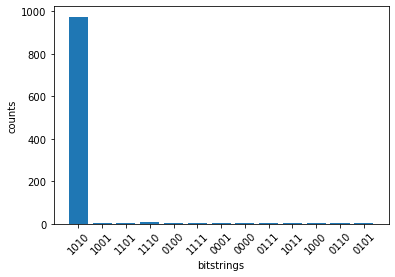

In [26]:
grover_solver_circuit = Circuit().grover(ES, 4, solutions = 1)
task = device.run(grover_solver_circuit, shots=int(1000))
result = task.result()
counts = result.measurement_counts
variable_bits = [c[0:4] for c in counts.keys()]
plt.bar(variable_bits, counts.values())
plt.xlabel('bitstrings');
plt.ylabel('counts');
_ = plt.xticks(rotation = 45)

In [27]:
for c, v in zip(counts, counts.values()):
    print(f'key: |{c[0:4]}>, measures: {v}')

key: |1010>, measures: 974
key: |1001>, measures: 3
key: |1101>, measures: 2
key: |1110>, measures: 6
key: |0100>, measures: 3
key: |1111>, measures: 2
key: |0001>, measures: 1
key: |0000>, measures: 2
key: |0111>, measures: 2
key: |1011>, measures: 1
key: |1000>, measures: 1
key: |0110>, measures: 1
key: |0101>, measures: 2


This concludes our attack, as we can see in over 97% of measurments we got a correct key, therefore the attack finishes with a success

In [28]:
#task = ionq_device.run(mc, s3_folder, shots=int(1000))
#print(task.id)

In [29]:
#result = task.result()
#counts = result.measurement_counts
#plt.bar([c[:4] for c in counts.keys()], counts.values());
#plt.xlabel('bitstrings');
#plt.ylabel('counts');